In [1]:
import pandas as pd
from mapper import util
from mapper import mappings
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls

CME-FVH2014.csv  CME-FVM2015.csv  CME-FVZ2014.csv
CME-FVH2015.csv  CME-FVU2014.csv  CME-FVZ2015.csv
CME-FVM2014.csv  CME-FVU2015.csv  continous_returns.ipynb


In [3]:
files = ["CME-FVH2014.csv", "CME-FVM2015.csv", "CME-FVZ2014.csv", "CME-FVH2015.csv",
         "CME-FVU2014.csv", "CME-FVZ2015.csv", "CME-FVM2014.csv", "CME-FVU2015.csv"]

def read_prices(files):

    settles = []
    for file in files:
        ast = file.split("-")[-1].split(".")[0]
        ast = ast[:2] + ast[3:] + ast[2]
        df = pd.read_csv(file, index_col=0, parse_dates=True)
        s = df.loc[:, "Settle"]
        s.index = pd.MultiIndex.from_product([s.index, [ast]])
        settles.append(s)
    
    prices = pd.concat(settles, axis=0).sort_index()
    return prices

In [4]:
prices = read_prices(files)
prices.head()

2012-12-31  FV2014H    123.16406
2013-01-02  FV2014H    123.10938
2013-01-03  FV2014H    122.88281
2013-01-04  FV2014H    122.80469
2013-01-07  FV2014H    122.82031
Name: Settle, dtype: float64

In [5]:
rets = prices.groupby(level=-1).pct_change()
rets.head()

2012-12-31  FV2014H         NaN
2013-01-02  FV2014H   -0.000444
2013-01-03  FV2014H   -0.001840
2013-01-04  FV2014H   -0.000636
2013-01-07  FV2014H    0.000127
Name: Settle, dtype: float64

In [6]:
cols = pd.MultiIndex.from_product([[0], ['front', 'back']])
idx = [-2, -1, 0]
transition = pd.DataFrame([[1.0, 0.0], [0.5, 0.5], [0.0, 1.0]], index=idx, columns=cols)

transition

0     
   front back
-2   1.0  0.0
-1   0.5  0.5
 0   0.0  1.0

In [7]:
# hacky way to get "last trade date" without actually looking at contract meta data
contract_dates = prices.reset_index().groupby("level_1").last().loc[:, "level_0"]

contract_dates.sort_values()

level_1
FV2014H   2014-03-31
FV2014M   2014-06-30
FV2014U   2014-09-30
FV2014Z   2014-12-31
FV2015H   2015-03-31
FV2015M   2015-06-30
FV2015U   2015-09-30
FV2015Z   2015-12-31
Name: level_0, dtype: datetime64[ns]

In [8]:
ts = rets.index.levels[0]
ts = ts[ts >= pd.Timestamp("2014-01-01")]
ts = ts[ts <= pd.Timestamp("2015-12-28")]
ts

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2015-12-14', '2015-12-15', '2015-12-16', '2015-12-17',
               '2015-12-18', '2015-12-21', '2015-12-22', '2015-12-23',
               '2015-12-24', '2015-12-28'],
              dtype='datetime64[ns]', length=501, freq=None)

### Roll over 2 days up to the last tradeable date

In [9]:
weights_pre_expiry = mappings.roller(ts, contract_dates, mappings.static_transition, transition=transition)
weights_pre_expiry.head()

,generic,0
date,contract,
2014-01-02,FV2014H,1.0
2014-01-03,FV2014H,1.0
2014-01-06,FV2014H,1.0
2014-01-07,FV2014H,1.0
2014-01-08,FV2014H,1.0


### Roll at the start of the month of expiry

In [10]:
cols = pd.MultiIndex.from_product([[0], ['front', 'back']])
idx = [0, 1]
transition_month = pd.DataFrame([[1.0, 0.0], [0.0, 1.0]], index=idx, columns=cols)

transition_month

0     
  front back
0   1.0  0.0
1   0.0  1.0

In [11]:
bom = contract_dates + pd.offsets.BMonthBegin(1)
weights_start_month = mappings.roller(ts, bom, mappings.static_transition, transition=transition_month)

/home/matthew/anaconda3/lib/python3.6/site-packages/pandas/tseries/index.py:817: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


In [12]:
rets.head()

2012-12-31  FV2014H         NaN
2013-01-02  FV2014H   -0.000444
2013-01-03  FV2014H   -0.001840
2013-01-04  FV2014H   -0.000636
2013-01-07  FV2014H    0.000127
Name: Settle, dtype: float64

In [13]:
continous_rets = util.calc_rets(rets, weights_pre_expiry)
continous_rets.head()

,0
date,
2014-01-02,0.000786
2014-01-03,-0.000458
2014-01-06,0.001309
2014-01-07,0.000915
2014-01-08,-0.003788


In [14]:
continous_rets_month_start = util.calc_rets(rets, weights_start_month)

In [15]:
contract_rets = pd.pivot_table(rets.reset_index(), values="Settle", index="level_0", columns="level_1")

In [16]:
contract_rets.head()

level_1,FV2014H,FV2014M,FV2014U,FV2014Z,FV2015H,FV2015M,FV2015U,FV2015Z
level_0,,,,,,,,
2012-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,-0.000444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.001840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,-0.000636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,0.000127,NaN,NaN,NaN,NaN,NaN,NaN,NaN


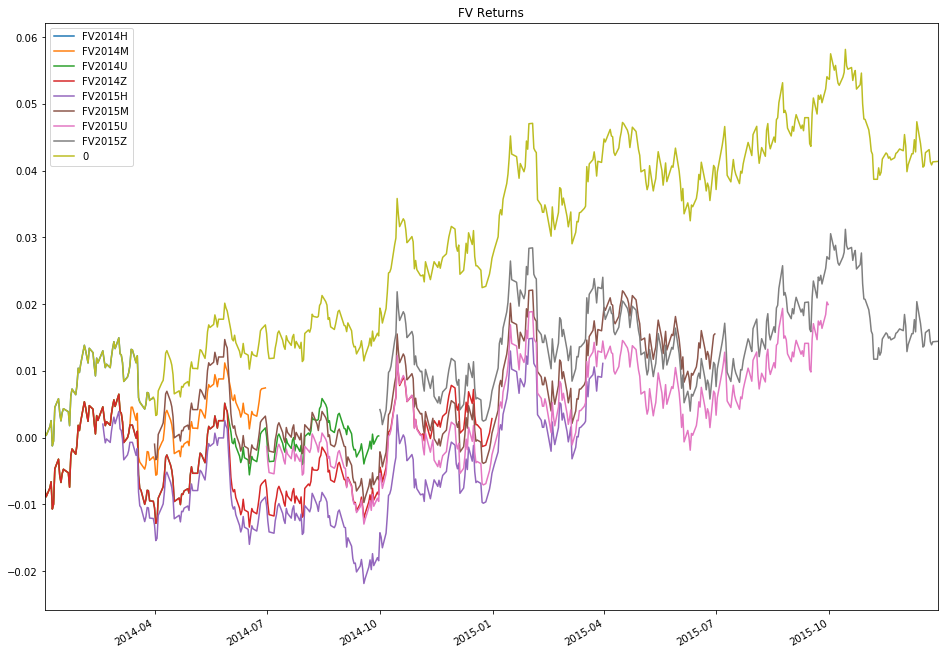

In [17]:
both_rets = pd.concat([contract_rets, continous_rets], axis=1)
both_rets.loc[ts, :].cumsum().plot(figsize=(16, 12), title="FV Returns")

In [18]:
both_rets = pd.concat([contract_rets, continous_rets], axis=1)
both_rets.loc[ts, :].cumsum().head()

,FV2014H,FV2014M,FV2014U,FV2014Z,FV2015H,FV2015M,FV2015U,FV2015Z,0
2014-01-02,0.000786,-0.007858,-0.007858,-0.007858,NaN,NaN,NaN,NaN,0.000786
2014-01-03,0.000328,-0.008848,-0.008848,-0.008848,NaN,NaN,NaN,NaN,0.000328
2014-01-06,0.001637,-0.007526,-0.007526,-0.007526,NaN,NaN,NaN,NaN,0.001637
2014-01-07,0.002552,-0.006603,-0.006603,-0.006603,NaN,NaN,NaN,NaN,0.002552
2014-01-08,-0.001236,-0.010689,-0.010689,-0.010689,NaN,NaN,NaN,NaN,-0.001236


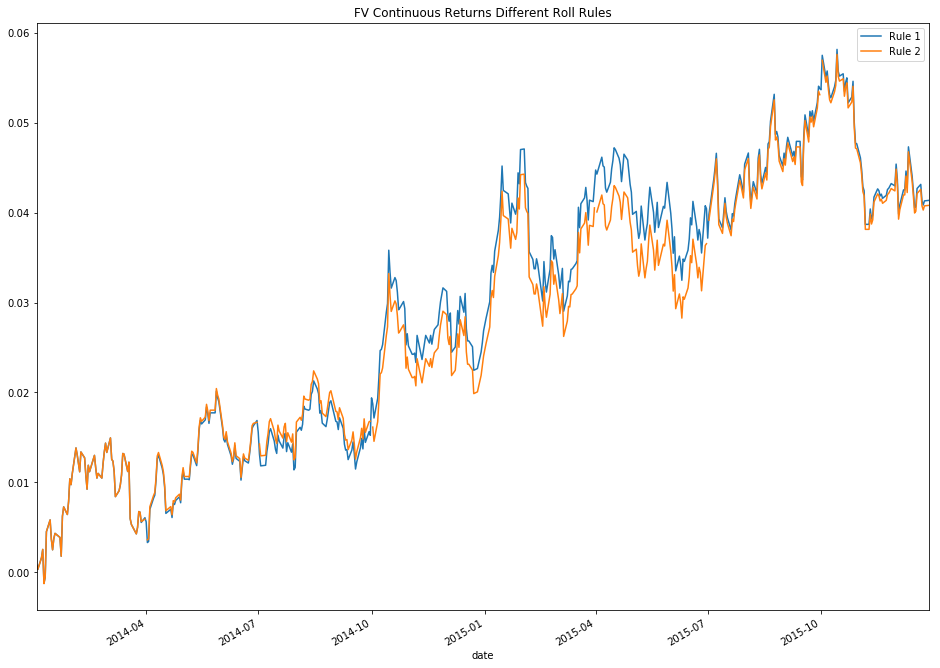

In [19]:
crets = pd.concat([continous_rets, continous_rets_month_start], axis=1)
crets.columns = ["Rule 1", "Rule 2"]
crets.cumsum().plot(figsize=(16, 12), title="FV Continuous Returns Different Roll Rules")